# Computing the instanton of the Muller-Brown system

Ref: *K. Müller and L. D. Brown, Theoretica chimica acta 53, 75 (1979)*

## Import statements

In [1]:
# Modify path environment variables to search for the local Pyritz installation in the repository.

import os, sys

pyritz_dir = "/".join(os.getcwd().split("/")[:-1])
sys.path.insert(0, pyritz_dir)

# Import statements

import pyritz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

## Define system

#### System:

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

where

$$
\begin{aligned}
U(x) & = \sum_{i=1}^4 u^{(i)} \\
u^{(i)}(x) & = A^{(i)} \exp \left\{ (x - r^{(i)})^T M^{(i)} (x - r^{(i)}) \right\} \\
a(x) & = - \nabla U = - 2 \sum_{i=1}^4 u^{(i)}(x) M^{(i)} ( x - r^{(i)})
\end{aligned}
$$

and

$$
\begin{aligned}
    \nabla a & = -\sum_{k=1}^4 2 u^{(k)}(x) \left[ 2 (M^{(k)} (x - r^{(k)}))\ (M^{(n)} (x - r^{(k)}))^T + M^{(k)} \right].
\end{aligned}
$$

where $(\nabla a)_{ij} = \nabla_i a_j = \frac{\partial a_j}{\partial x_i}$.

#### Lagrangian:

$$
L(x, x') = |x'| |a(x)| - x' \cdot a(x)
$$

#### Derivatives of the Lagrangian:

$$
\begin{aligned}
\frac{\partial L}{\partial x_i} & = \sum_{j=1}^{\text{dim}} \left[ \nabla_i a_j( x ) \cdot \left( |\dot x| \hat{a}_j(x) - \dot x_j \right) \right] \\
\frac{\partial L}{\partial x'_i} & = |a(x)| \hat{x}'_i - a_i(x)
\end{aligned}
$$

In [2]:
# System parameters

m_As = np.array([-200, -100, -170, 15])
m_rs = np.array([[1, 0], [0, 0.5], [-0.5, 1.5], [-1, 1]])
m_a = np.array([-1, -1, -6.5, .7])
m_b = np.array([0, 0, 11, .6])
m_c = np.array([-10, -10, -6.5, .7])
m_Ms = np.array([[[-1, 0], [0, -10]],
    [[-1, 0], [0, -10]],
    [[-6.5, 11./2], [11./2, -6.5]],
    [[0.7, 0.6/2], [0.6/2, 0.7]]])

# Fixed points

e_xa = np.array([-0.5582236346330538, 1.4417258418047276])
e_xb = np.array([-0.05001082299987612, 0.46669410487452595])
e_xc = np.array([0.6234994049308765, 0.028037758528685675])
e_xs1 = np.array([-0.8220015587325014, 0.6243128028149082])
e_xs2 = np.array([0.2124865820007588, 0.29298832511742257])

# System Lagrangian

def system_a(xs):
    rs = np.zeros((2, 4))
    us = np.zeros(4)
    sas = np.zeros(2)
    
    for i in range(4):
        rs[:, i] = m_Ms[i, :, :].dot( xs[:] - m_rs[i, :] )
        us[i] = m_As[i]*np.exp( (xs[:] - m_rs[i, :]).dot(rs[:, i]) )
        sas[:] += -2*us[i]*rs[:, i]
        
    return sas

def system_potential(x,y):
    pot=np.zeros(x.shape)
    for i in range(4):
        dd = m_a[i]*(x-m_rs[i][0])**2 + m_b[i]*(x-m_rs[i][0])*(y-m_rs[i][1]) + m_c[i]*(y-m_rs[i][1])**2
        pot += m_As[i]*np.exp(dd) 
        
    return pot

def lagrangian(ls, dxls, dvls, path, us, args):
    xs, vs = path
    
    # Compute drift
    
    rs = np.zeros((xs.shape[0], m_As.size, ls.size))
    us = np.zeros((m_As.size, ls.size))
    sas = np.zeros((xs.shape[0], ls.size))
    
    for i in range(m_As.size):
        us[i, :] = m_As[i]*np.exp(
            m_a[i]*(xs[0,:]-m_rs[i][0])**2 + m_b[i]*(xs[0,:]-m_rs[i][0])*(xs[1,:]-m_rs[i][1]) +
            m_c[i]*(xs[1,:]-m_rs[i][1])**2)
        rs[0, i, :] = m_a[i]*(xs[0,:]-m_rs[i,0])+0.5*m_b[i]*(xs[1,:]-m_rs[i][1])
        rs[1, i, :] = m_c[i]*(xs[1,:]-m_rs[i,1])+0.5*m_b[i]*(xs[0,:]-m_rs[i][0])
        sas[0, :] += -2*us[i, :]*rs[0, i, :]
        sas[1, :] += -2*us[i, :]*rs[1, i, :]
    
    # Compute lagrangian
    
    v_norms = np.linalg.norm(vs, axis=0)
    sa_norms = np.linalg.norm(sas, axis=0)
    vs_dot_sas = np.einsum("ij,ij->j", vs, sas)
    
    ls[:] = v_norms * sa_norms - vs_dot_sas
    
    if not dxls is None:

        ## Compute dL/dx

        da = np.zeros( (xs.shape[0], xs.shape[0], len(ls)) )
        for j in range(ls.size):
            for i in range(4):
                da[:, :, j] += - 2 * us[i, j] * (2*np.outer(rs[:, i, j], rs[:, i, j]) + m_Ms[i])
                
        f = np.where(sa_norms!=0)
        sa_units = np.zeros(sas.shape)
        sa_units[:, f] = sas[:, f]/sa_norms[f]

        dxls[:] = np.einsum("jki,ki->ji", da, v_norms*sa_units - vs)

        ## Compute dL/dv

        f = np.where(v_norms!=0)
        avs = np.zeros(vs.shape)
        avs[:, f] = vs[:, f]*sa_norms[f]/v_norms[f]

        dvls[:] = avs - sas

## Computing the instanton

### Gradient-based optimisation

In [6]:
x1 = e_xa
x2 = e_xc

n = 8
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in subtract
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in multiply
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in multiply
/home/lukas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in multiply


S[alpha0] = 419.8926799365788
S[alpha]  = 229.04697336239389


#### Instanton plot

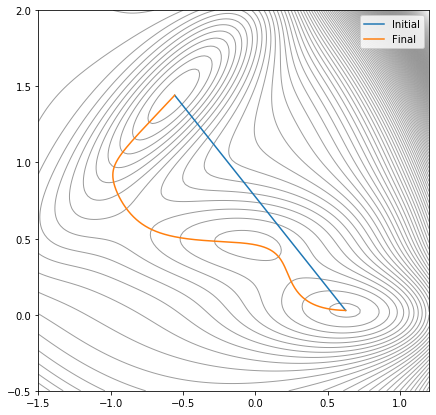

In [7]:
us = np.linspace(-1, 1, 1000)

paths = [
    (action.get_full_alpha(alpha0), "Initial"),
    (action.get_full_alpha(alpha), "Final")
]

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, us)
    plt.plot(xs[0,:], xs[1,:], label=_label)

X, Y = np.meshgrid(np.linspace(-1.5, 1.2, 128), np.linspace(-.5, 2, 128))
plt.contour(X, Y, system_potential(X, Y), 256, cmap='gray', linewidths=1, alpha=0.4);

plt.legend()
fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)

### Gradient-free optimisation

In [5]:
x1 = e_xa
x2 = e_xc

n = 10
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 419.8926812385322
S[alpha]  = 229.2488297729296


#### Instanton plot

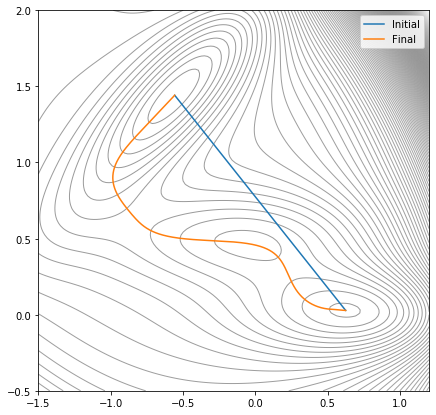

In [6]:
us = np.linspace(-1, 1, 1000)

paths = [
    (action.get_full_alpha(alpha0), "Initial"),
    (action.get_full_alpha(alpha), "Final")
]

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, us)
    plt.plot(xs[0,:], xs[1,:], label=_label)

X, Y = np.meshgrid(np.linspace(-1.5, 1.2, 128), np.linspace(-.5, 2, 128))
plt.contour(X, Y, system_potential(X, Y), 256, cmap='gray', linewidths=1, alpha=0.4);

plt.legend()
fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)